**PRÁCTICA 4 (REALIZADA EN CLASE JUNTO AL PROFESOR) (NO EVALUABLE)**

Miembros del grupo:

- **Javier Quesada Pajares**
- **Miguel González García**
- **Jorge del Castillo Gómez** 

# Ataque adversario a una red neuronal


In [8]:
# Dependencias adicionales
%pip install -q opencv-python
%pip install -q nnfs

Si antes has hecho alguna actividad con redes neuronales, probablemente conoces la base de datos MNIST con imágenes de dígitos manuscritos. El problema de esta base de datos es que su sencillez hace que sea fácil alcanzar altas precisiones ($>99\%$), limitando el aprendizaje sobre el efecto de distintos parámetros. Como alternativa, Zalando publicó en 2017 la base de datos *Fashion MNIST*, una versión más compleja con imágenes de prendas, proporcionando 60000 muestras para entrenamiento y 10000 para prueba, en formato .png y debidamente categorizadas para investigación en aprendizaje profundo.

Vamos a usar la estructura computacional creada en clases anteriores para entrenar una red que aprenda a categorizar las prendas de esta base de datos. Una vez entrenada la red, realizaremos un ataque adversario.

### Descarga de datos

Ejecutando la siguiente celda descargarás la base de datos *Fashion MNIST* y la descomprimirás en la carpeta de trabajo.

In [9]:
# Descarga la base de datos
from zipfile import ZipFile
import os
import urllib.request

URL = 'https://drive.upm.es/s/cqehBT3JtjPtD1a/download'
FILE = 'fashion_mnist_images.zip'
FOLDER = 'fashion_mnist_images'

if not os.path.isfile(FILE):
    print(f'Downloading {URL} and saving as {FILE}...')
    urllib.request.urlretrieve(URL, FILE)
    print('Unzipping images...')
    with ZipFile(FILE) as zip_images:
        zip_images.extractall(FOLDER)
    print('Done!')

### Código de otras clases

Ejecuta la siguiente celda para poder usar funciones y clases que desarrollamos en otras clases.

In [10]:
import numpy as np
import nnfs
import os
import cv2
import pickle
import copy

nnfs.init()

# Dense layer
class Layer_Dense:
    # Layer initialization
    def __init__(self, n_inputs, n_neurons, weight_regularizer_l1=0, weight_regularizer_l2=0,
                 bias_regularizer_l1=0, bias_regularizer_l2=0):
        # Initialize weights and biases
        self.weights = 0.01 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))
        # Set regularization strength
        self.weight_regularizer_l1 = weight_regularizer_l1
        self.weight_regularizer_l2 = weight_regularizer_l2
        self.bias_regularizer_l1 = bias_regularizer_l1
        self.bias_regularizer_l2 = bias_regularizer_l2

    # Forward pass
    def forward(self, inputs, training):
        # Remember input values
        self.inputs = inputs
        # Calculate output values from inputs, weights and biases
        self.output = np.dot(inputs, self.weights) + self.biases

    # Backward pass
    def backward(self, dvalues):
        # Gradients on parameters
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)

        # Gradients on regularization
        # L1 on weights
        if self.weight_regularizer_l1 > 0:
            dL1 = np.ones_like(self.weights)
            dL1[self.weights < 0] = -1
            self.dweights += self.weight_regularizer_l1 * dL1
        # L2 on weights
        if self.weight_regularizer_l2 > 0:
            self.dweights += 2 * self.weight_regularizer_l2 * self.weights
        # L1 on biases
        if self.bias_regularizer_l1 > 0:
            dL1 = np.ones_like(self.biases)
            dL1[self.biases < 0] = -1
            self.dbiases += self.bias_regularizer_l1 * dL1
        # L2 on biases
        if self.bias_regularizer_l2 > 0:
            self.dbiases += 2 * self.bias_regularizer_l2 * self.biases

        # Gradient on values
        self.dinputs = np.dot(dvalues, self.weights.T)


# Input "layer"
class Layer_Input:
    # Forward pass
    def forward(self, inputs, training):
        self.output = inputs


# ReLU activation
class Activation_ReLU:
    # Forward pass
    def forward(self, inputs, training):
        # Remember input values
        self.inputs = inputs
        # Calculate output values from inputs
        self.output = np.maximum(0, inputs)

    # Backward pass
    def backward(self, dvalues):
        # Since we need to modify the original variable,
        # let's make a copy of the values first
        self.dinputs = dvalues.copy()
        # Zero gradient where input values were negative
        self.dinputs[self.inputs <= 0] = 0

    # Calculate predictions for outputs
    def predictions(self, outputs):
        return outputs


# Softmax activation
class Activation_Softmax:
    # Forward pass
    def forward(self, inputs, training):
        # Remember input values
        self.inputs = inputs
        # Get unnormalized probabilities
        exp_values = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))
        # Normalize them for each sample
        probabilities = exp_values / np.sum(exp_values, axis=1, keepdims=True)
        self.output = probabilities

    # Backward pass
    def backward(self, dvalues):
        # Create an uninitialized array
        self.dinputs = np.empty_like(dvalues)
        # Enumerate outputs and gradients
        for index, (single_output, single_dvalues) in enumerate(zip(self.output, dvalues)):
            # Flatten output array
            single_output = single_output.reshape(-1, 1)
            # Calculate the Jacobian matrix of the output
            jacobian_matrix = np.diagflat(single_output) - np.dot(single_output, single_output.T)
            # Calculate sample-wise gradient and add it to the array of sample gradients
            self.dinputs[index] = np.dot(jacobian_matrix, single_dvalues)

    # Calculate predictions for outputs
    def predictions(self, outputs):
        return np.argmax(outputs, axis=1)


class Optimizer_Adam:
    # Initialize optimizer - set settings
    def __init__(self, learning_rate=0.001, decay=0., epsilon=1e-7, beta_1=0.9, beta_2=0.999):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon
        self.beta_1 = beta_1
        self.beta_2 = beta_2

    # Call once before any parameter updates
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * (1. / (1. + self.decay * self.iterations))

    # Update parameters
    def update_params(self, layer):
        # If layer does not contain cache arrays, create them
        if not hasattr(layer, 'weight_cache'):
            layer.weight_momentums = np.zeros_like(layer.weights)
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_momentums = np.zeros_like(layer.biases)
            layer.bias_cache = np.zeros_like(layer.biases)

        # Update momentum with current gradients
        layer.weight_momentums = self.beta_1 * layer.weight_momentums + (1 - self.beta_1) * layer.dweights
        layer.bias_momentums = self.beta_1 * layer.bias_momentums + (1 - self.beta_1) * layer.dbiases

        # Get corrected momentum
        weight_momentums_corrected = layer.weight_momentums / (1 - self.beta_1 ** (self.iterations + 1))
        bias_momentums_corrected = layer.bias_momentums / (1 - self.beta_1 ** (self.iterations + 1))

        # Update cache with squared current gradients
        layer.weight_cache = self.beta_2 * layer.weight_cache + (1 - self.beta_2) * layer.dweights ** 2
        layer.bias_cache = self.beta_2 * layer.bias_cache + (1 - self.beta_2) * layer.dbiases ** 2

        # Get corrected cache
        weight_cache_corrected = layer.weight_cache / (1 - self.beta_2 ** (self.iterations + 1))
        bias_cache_corrected = layer.bias_cache / (1 - self.beta_2 ** (self.iterations + 1))

        # Vanilla SGD parameter update + normalization with square rooted cache
        layer.weights += -self.current_learning_rate * weight_momentums_corrected / (np.sqrt(weight_cache_corrected) + self.epsilon)
        layer.biases += -self.current_learning_rate * bias_momentums_corrected / (np.sqrt(bias_cache_corrected) + self.epsilon)

    # Call once after any parameter updates
    def post_update_params(self):
        self.iterations += 1

import numpy as np

class Loss:
    def regularization_loss(self):
        # Regularization loss calculation
        # 0 by default
        regularization_loss = 0

        # Iterate all trainable layers for regularization loss
        for layer in self.trainable_layers:
            # L1 regularization - weights (calculate only when factor greater than 0)
            if layer.weight_regularizer_l1 > 0:
                regularization_loss += layer.weight_regularizer_l1 * np.sum(np.abs(layer.weights))

            # L2 regularization - weights
            if layer.weight_regularizer_l2 > 0:
                regularization_loss += layer.weight_regularizer_l2 * np.sum(layer.weights * layer.weights)

            # L1 regularization - biases (calculate only when factor greater than 0)
            if layer.bias_regularizer_l1 > 0:
                regularization_loss += layer.bias_regularizer_l1 * np.sum(np.abs(layer.biases))

            # L2 regularization - biases
            if layer.bias_regularizer_l2 > 0:
                regularization_loss += layer.bias_regularizer_l2 * np.sum(layer.biases * layer.biases)

        return regularization_loss


    # Set/remember trainable layers
    def remember_trainable_layers(self, trainable_layers):
        self.trainable_layers = trainable_layers

    # Calculates the data and regularization losses
    # given model output and ground truth values
    def calculate(self, output, y, *, include_regularization=False):
        sample_losses = self.forward(output, y)
        data_loss = np.mean(sample_losses)
        self.accumulated_sum += np.sum(sample_losses)
        self.accumulated_count += len(sample_losses)

        if not include_regularization:
            return data_loss

        return data_loss, self.regularization_loss()

    # Calculates accumulated loss
    def calculate_accumulated(self, *, include_regularization=False):
        data_loss = self.accumulated_sum / self.accumulated_count

        if not include_regularization:
            return data_loss

        return data_loss, self.regularization_loss()

    # Reset variables for accumulated loss
    def new_pass(self):
        self.accumulated_sum = 0
        self.accumulated_count = 0

# Cross-entropy loss
class Loss_CategoricalCrossentropy(Loss):
    # Forward pass
    def forward(self, y_pred, y_true):
        samples = len(y_pred)
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)

        if len(y_true.shape) == 1:
            correct_confidences = y_pred_clipped[range(samples), y_true]
        elif len(y_true.shape) == 2:
            correct_confidences = np.sum(y_pred_clipped * y_true, axis=1)

        negative_log_likelihoods = -np.log(correct_confidences)
        return negative_log_likelihoods

    # Backward pass
    def backward(self, dvalues, y_true):
        samples = len(dvalues)
        labels = len(dvalues[0])

        if len(y_true.shape) == 1:
            y_true = np.eye(labels)[y_true]

        self.dinputs = -y_true / dvalues
        self.dinputs = self.dinputs / samples

# Softmax classifier - combined Softmax activation
# and cross-entropy loss for faster backward step
class Activation_Softmax_Loss_CategoricalCrossentropy():
    # Backward pass
    def backward(self, dvalues, y_true):
        samples = len(dvalues)

        if len(y_true.shape) == 2:
            y_true = np.argmax(y_true, axis=1)

        self.dinputs = dvalues.copy()
        self.dinputs[range(samples), y_true] -= 1
        self.dinputs = self.dinputs / samples

# Common accuracy class
class Accuracy:
    # Calculates an accuracy
    # given predictions and ground truth values
    def calculate(self, predictions, y):
        # Get comparison results
        comparisons = self.compare(predictions, y)
        # Calculate an accuracy
        accuracy = np.mean(comparisons)
        # Add accumulated sum of matching values and sample count
        self.accumulated_sum += np.sum(comparisons)
        self.accumulated_count += len(comparisons)
        # Return accuracy
        return accuracy

    # Calculates accumulated accuracy
    def calculate_accumulated(self):
        # Calculate an accuracy
        accuracy = self.accumulated_sum / self.accumulated_count
        # Return the data and regularization losses
        return accuracy

    # Reset variables for accumulated accuracy
    def new_pass(self):
        self.accumulated_sum = 0
        self.accumulated_count = 0

# Accuracy calculation for classification model
class Accuracy_Categorical(Accuracy):
    def __init__(self, *, binary=False):
        # Binary mode?
        self.binary = binary

    # No initialization is needed
    def init(self, y):
        pass

    # Compares predictions to the ground truth values
    def compare(self, predictions, y):
        if not self.binary and len(y.shape) == 2:
            y = np.argmax(y, axis=1)
        return predictions == y

class Model:
    def __init__(self):
        # Create a list of network objects
        self.layers = []
        # Softmax classifier's output object
        self.softmax_classifier_output = None

    def add(self, layer):
        # Add objects to the model
        self.layers.append(layer)

    def set(self, *, loss, optimizer, accuracy):
        # Set loss, optimizer and accuracy
        self.loss = loss
        self.optimizer = optimizer
        self.accuracy = accuracy

    def finalize(self):
        # Finalize the model
        # Create and set the input layer
        self.input_layer = Layer_Input()
        # Count all the objects
        layer_count = len(self.layers)
        # Initialize a list containing trainable layers
        self.trainable_layers = []

        # Iterate the objects
        for i in range(layer_count):
            # If it's the first layer, the previous layer object is the input layer
            if i == 0:
                self.layers[i].prev = self.input_layer
                self.layers[i].next = self.layers[i + 1]
            # All layers except for the first and the last
            elif i < layer_count - 1:
                self.layers[i].prev = self.layers[i - 1]
                self.layers[i].next = self.layers[i + 1]
            # The last layer - the next object is the loss
            else:
                self.layers[i].prev = self.layers[i - 1]
                self.layers[i].next = self.loss
                self.output_layer_activation = self.layers[i]

            # If layer contains an attribute called "weights", it's a trainable layer
            if hasattr(self.layers[i], 'weights'):
                self.trainable_layers.append(self.layers[i])

        # Update loss object with trainable layers
        self.loss.remember_trainable_layers(self.trainable_layers)

        # If output activation is Softmax and loss function is Categorical Cross-Entropy
        if isinstance(self.layers[-1], Activation_Softmax) and \
           isinstance(self.loss, Loss_CategoricalCrossentropy):
            self.softmax_classifier_output = Activation_Softmax_Loss_CategoricalCrossentropy()

    def train(self, X, y, *, epochs=1, batch_size=None, print_every=1, validation_data=None):
        # Initialize accuracy object
        self.accuracy.init(y)

        # Default value if batch size is not being set
        train_steps = 1

        # If batch_size is provided, calculate the number of steps per epoch
        if batch_size is not None:
            train_steps = len(X) // batch_size
            # Include any remaining data as a smaller final batch
            if train_steps * batch_size < len(X):
                train_steps += 1

        # Perform training over the number of specified epochs
        for epoch in range(1, epochs + 1):
            print(f'Epoch {epoch}')

            # Reset accumulated values in loss and accuracy objects for each epoch
            self.loss.new_pass()
            self.accuracy.new_pass()

            # Iterate over steps (batches)
            for step in range(train_steps):
                # If batch_size is not set, use the entire dataset
                if batch_size is None:
                    batch_X = X
                    batch_y = y
                # Otherwise slice a batch
                else:
                    batch_X = X[step * batch_size:(step + 1) * batch_size]
                    batch_y = y[step * batch_size:(step + 1) * batch_size]

                # Perform the forward pass
                output = self.forward(batch_X, training=True)

                # Calculate loss and perform backward pass
                data_loss, regularization_loss = self.loss.calculate(output, batch_y, include_regularization=True)
                loss = data_loss + regularization_loss
                predictions = self.output_layer_activation.predictions(output)
                accuracy = self.accuracy.calculate(predictions, batch_y)
                self.backward(output, batch_y)

                # Update weights and biases
                self.optimizer.pre_update_params()
                for layer in self.trainable_layers:
                    self.optimizer.update_params(layer)
                self.optimizer.post_update_params()

                # Print summary
                if step % print_every == 0 or step == train_steps - 1:
                    print(f'step: {step}, ' +
                          f'acc: {accuracy:.3f}, ' +
                          f'loss: {loss:.3f} (' +
                          f'data_loss: {data_loss:.3f}, ' +
                          f'reg_loss: {regularization_loss:.3f}), ' +
                          f'lr: {self.optimizer.current_learning_rate}')

            # Get and print epoch loss and accuracy
            epoch_data_loss, epoch_regularization_loss = self.loss.calculate_accumulated(include_regularization=True)
            epoch_loss = epoch_data_loss + epoch_regularization_loss
            epoch_accuracy = self.accuracy.calculate_accumulated()

            print(f'Epoch {epoch} completed: ' +
                  f'acc: {epoch_accuracy:.3f}, ' +
                  f'loss: {epoch_loss:.3f} (' +
                  f'data_loss: {epoch_data_loss:.3f}, ' +
                  f'reg_loss: {epoch_regularization_loss:.3f}), ' +
                  f'lr: {self.optimizer.current_learning_rate}')

            # If there's validation data, evaluate the model
            if validation_data is not None:
                self.evaluate(*validation_data, batch_size=batch_size)


    def evaluate(self, X_val, y_val, *, batch_size=None):
        # Evaluates the model using passed-in dataset
        # Default value if batch size is not being set
        validation_steps = 1

        # Calculate number of steps if batch_size is not None
        if batch_size is not None:
            validation_steps = len(X_val) // batch_size
            # Dividing rounds down. If there are some remaining data but not a full batch, this won't include it
            # Add `1` to include this not full batch
            if validation_steps * batch_size < len(X_val):
                validation_steps += 1

        # Reset accumulated values in loss and accuracy objects
        self.loss.new_pass()
        self.accuracy.new_pass()

        # Iterate over steps
        for step in range(validation_steps):
            # If batch size is not set, train using one step and full dataset
            if batch_size is None:
                batch_X = X_val
                batch_y = y_val
            # Otherwise slice a batch
            else:
                batch_X = X_val[step*batch_size:(step+1)*batch_size]
                batch_y = y_val[step*batch_size:(step+1)*batch_size]

            # Perform the forward pass
            output = self.forward(batch_X, training=False)

            # Calculate the loss
            self.loss.calculate(output, batch_y)

            # Get predictions and calculate an accuracy
            predictions = self.output_layer_activation.predictions(output)
            self.accuracy.calculate(predictions, batch_y)

        # Get and print validation loss and accuracy
        validation_loss = self.loss.calculate_accumulated()
        validation_accuracy = self.accuracy.calculate_accumulated()

        # Print a summary
        print(f'validation, acc: {validation_accuracy:.3f}, loss: {validation_loss:.3f}')

    def predict(self, X, *, batch_size=None):
        # Predicts on the samples
        # Default value if batch size is not being set
        prediction_steps = 1

        # Calculate number of steps if batch_size is not None
        if batch_size is not None:
            prediction_steps = len(X) // batch_size
            # Dividing rounds down. If there are some remaining data but not a full batch, this won't include it
            # Add `1` to include this not full batch
            if prediction_steps * batch_size < len(X):
                prediction_steps += 1

        # Model outputs
        output = []

        # Iterate over steps
        for step in range(prediction_steps):
            # If batch size is not set, use the full dataset
            if batch_size is None:
                batch_X = X
            # Otherwise slice a batch
            else:
                batch_X = X[step*batch_size:(step+1)*batch_size]

            # Perform the forward pass
            batch_output = self.forward(batch_X, training=False)

            # Append batch prediction to the list of predictions
            output.append(batch_output)

        # Stack and return results
        return np.vstack(output)

    def forward(self, X, training):
        # The input layer simply forwards the input
        self.input_layer.forward(X, training)

        # Iterate through the network layers and sequentially pass the output
        # of the previous layer as input to the next layer
        for layer in self.layers:
            layer.forward(layer.prev.output, training)

        # Return the output of the last layer which is the actual output of the network
        return layer.output

    def backward(self, output, y):
        # If we're using the combined softmax_crossentropy loss,
        # we can streamline the backward pass
        if self.softmax_classifier_output is not None:
            # First, backward pass through the combined softmax_crossentropy layer
            self.softmax_classifier_output.backward(output, y)
            # Set the first layer to be iterated over in the next for loop
            # to be the last dense layer
            input_to_backward = self.softmax_classifier_output.dinputs
            layers = self.layers[:-1]  # all layers except the last softmax
        else:
            # If not using combined loss, backward pass through the loss first
            self.loss.backward(output, y)
            # The input to the next layer's backward pass is the gradient from the loss
            input_to_backward = self.loss.dinputs
            layers = self.layers  # all layers need to be iterated over

        # Iterate backwards through the network layers
        # to pass the error gradient back to the previous layers
        for layer in reversed(layers):
            layer.backward(input_to_backward)
            # The input for the next layer backward pass is the gradient w.r.t. input
            # of the current layer, which is stored in layer.dinputs
            input_to_backward = layer.dinputs

    def get_parameters(self):
        # Retrieves and returns parameters of trainable layers
        parameters = []
        for layer in self.trainable_layers:
            parameters.append(layer.get_parameters())
        return parameters

    def set_parameters(self, parameters):
        # Updates the model with new parameters
        for parameter_set, layer in zip(parameters, self.trainable_layers):
            layer.set_parameters(*parameter_set)

    def save_parameters(self, path):
        # Saves the parameters to a file
        with open(path, 'wb') as f:
            pickle.dump(self.get_parameters(), f)

    def load_parameters(self, path):
        # Loads the weights and updates a model instance with them
        with open(path, 'rb') as f:
            self.set_parameters(pickle.load(f))

    def save(self, path):
        # Saves the model
        model = copy.deepcopy(self)
        model.loss.new_pass()
        model.accuracy.new_pass()

        # Remove data from the input layer and gradients from the loss object
        model.input_layer.__dict__.pop('output', None)
        model.loss.__dict__.pop('dinputs', None)

        # For each layer remove inputs, output and dinputs properties
        for layer in model.layers:
            for property in ['inputs', 'output', 'dinputs', 'dweights', 'dbiases']:
                layer.__dict__.pop(property, None)

        # Save the model
        with open(path, 'wb') as f:
            pickle.dump(model, f)

    @staticmethod
    def load(path):
        # Loads and returns a model
        with open(path, 'rb') as f:
            model = pickle.load(f)
        return model

# Loads a MNIST dataset
def load_mnist_dataset(dataset, path):
    # Scan all the directories and create a list of labels
    labels = os.listdir(os.path.join(path, dataset))

    # Create lists for samples and labels
    X = []
    y = []

    # For each label folder
    for label in labels:
        # And for each image in given folder
        for file in os.listdir(os.path.join(path, dataset, label)):
            # Read the image
            image = cv2.imread(os.path.join(path, dataset, label, file), cv2.IMREAD_UNCHANGED)
            # And append it and a label to the lists
            X.append(image)
            y.append(label)

    # Convert the data to proper numpy arrays and return
    return np.array(X), np.array(y).astype('uint8')

# MNIST dataset (train + test)
def create_data_mnist(path):
    # Load both sets separately
    X, y = load_mnist_dataset('train', path)
    X_test, y_test = load_mnist_dataset('test', path)

    # And return all the data
    return X, y, X_test, y_test


### Entrenamiento

Realiza el entrenamiento de la red ejecutando la siguiente celda. Analiza el flujo de código y observa las similitudes con el *script* que usábamos para entrenar la red en el caso de la triple espiral.

In [11]:
import numpy as np

# Assuming previous definitions of Model, Layer_Dense, Activation_ReLU, etc., are available

# Create dataset
X, y, X_test, y_test = create_data_mnist('fashion_mnist_images')

# Shuffle the training dataset
keys = np.array(range(X.shape[0]))
np.random.shuffle(keys)
X = X[keys]
y = y[keys]

# Scale and reshape samples
X = (X.reshape(X.shape[0], -1).astype(np.float32) - 127.5) / 127.5
X_test = (X_test.reshape(X_test.shape[0], -1).astype(np.float32) - 127.5) / 127.5

# Instantiate the model
model = Model()

# Add layers
model.add(Layer_Dense(X.shape[1], 128))
model.add(Activation_ReLU())
model.add(Layer_Dense(128, 128))
model.add(Activation_ReLU())
model.add(Layer_Dense(128, 10))
model.add(Activation_Softmax())

# Set loss, optimizer, and accuracy objects
model.set(
    loss=Loss_CategoricalCrossentropy(),
    optimizer=Optimizer_Adam(decay=1e-3),
    accuracy=Accuracy_Categorical()
)

# Finalize the model
model.finalize()

# Train the model
model.train(X, y, validation_data=(X_test, y_test), epochs=10, batch_size=128, print_every=100)
model.save('fashion_mnist.model')


Epoch 1
step: 0, acc: 0.062, loss: 2.303 (data_loss: 2.303, reg_loss: 0.000), lr: 0.001
step: 100, acc: 0.703, loss: 0.642 (data_loss: 0.642, reg_loss: 0.000), lr: 0.0009090909090909091
step: 200, acc: 0.781, loss: 0.675 (data_loss: 0.675, reg_loss: 0.000), lr: 0.0008333333333333334
step: 300, acc: 0.867, loss: 0.455 (data_loss: 0.455, reg_loss: 0.000), lr: 0.0007692307692307692
step: 400, acc: 0.852, loss: 0.485 (data_loss: 0.485, reg_loss: 0.000), lr: 0.0007142857142857143
step: 468, acc: 0.802, loss: 0.454 (data_loss: 0.454, reg_loss: 0.000), lr: 0.000681198910081744
Epoch 1 completed: acc: 0.761, loss: 0.651 (data_loss: 0.651, reg_loss: 0.000), lr: 0.000681198910081744
validation, acc: 0.819, loss: 0.497
Epoch 2
step: 0, acc: 0.820, loss: 0.517 (data_loss: 0.517, reg_loss: 0.000), lr: 0.0006807351940095304
step: 100, acc: 0.883, loss: 0.360 (data_loss: 0.360, reg_loss: 0.000), lr: 0.0006373486297004461
step: 200, acc: 0.836, loss: 0.561 (data_loss: 0.561, reg_loss: 0.000), lr: 0.00

### Predicción de datos nuevos

Vamos a ver si nuestro modelo entrenado es capaz de predecir correctamente qué tipo de prenda es la que aparece en una imagen que confeccionemos nosotros. Para obtener esta imagen, puedes dibujarla en Paint, hacer una foto a una prenda, descargarla de internet, o simplemente descargarte [esta](https://drive.upm.es/s/nAFaGwXecyz83xK/download).

Realiza un forward pass con esta imagen como input para ver la predicción de la red. Antes, preprocesa la imagen como se describe a continuación, para que coincida con el formato de los datos de entrenamiento.
 - Conviértela a escala de grises
 - Cambia su resolución a 28x28 pixeles
 - Invierte los colores.
 - Convierte la imagen en un array 1D, y normaliza el rango de valores a $[-1, 1]$.

In [ ]:
# from openai import OpenAI
# client = OpenAI()

# response = client.images.generate(
#     model="dall-e-3",
#     prompt="A drawing of a Sandal in the style of the Fashion MNIST dataset",
#     size="256x256",
#     quality="standard",
#     n=1
# )

# image_url = response.data[0].url

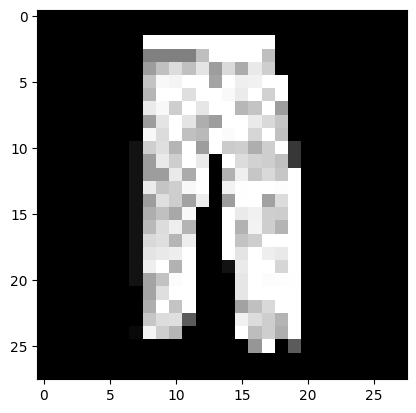

In [19]:
# Predicción de datos nuevos

# Por si las necesitas, estas son las etiquetas de la base de datos:
fashion_mnist_labels = {
                        0: 'T-shirt/top',
                        1: 'Trouser',
                        2: 'Pullover',
                        3: 'Dress',
                        4: 'Coat',
                        5: 'Sandal',
                        6: 'Shirt',
                        7: 'Sneaker',
                        8: 'Bag',
                        9: 'Ankle boot'
                        }


import matplotlib.pyplot as plt

study_image = "pants.png"

# Cargo imagen en color
image_data = cv2.imread(study_image, cv2.IMREAD_UNCHANGED)

# Cargo imagen en escala de grises
image_data = cv2.imread(study_image, cv2.IMREAD_GRAYSCALE)

# Cambio la resolución
image_data = cv2.resize(image_data, (28, 28))

# La invierto
image_data = 255 - image_data

plt.imshow(cv2.cvtColor(image_data, cv2.COLOR_BGR2RGB))
plt.show()

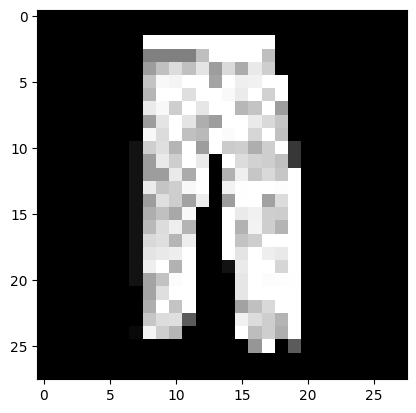

La predicción es Coat


In [20]:

image_data2 = (image_data.reshape(1, -1).astype(np.float32) - 127.5) / 127.5

plt.imshow(cv2.cvtColor(image_data, cv2.COLOR_BGR2RGB))
plt.show()

# variable 'model'
# model = Model.load("fashion_mnist.model")

confidences = model.predict(image_data2)
predictions = model.output_layer_activation.predictions(confidences)

prediction = fashion_mnist_labels[predictions[0]]

print(f"La predicción es {prediction}")

### Función para realizar el ataque adversario

Programa una función llamada ```generate_adversarial_rnn(model, image_data, true_label)``` que modifique una imagen ```image_data``` intentando encontrar otra imagen que ataque a la red con éxito. La función debe devolver una tupla de cuatro valores:
 - La imagen modificada con la que realizar el ataque.
 - La predicción de la red para la imagen modificada.
 - La perturbación aplicada.
 - Un booleano que indique si el ataque es exitoso o no.

In [29]:
# Función para realizar el ataque adversario

def generate_adversarial_rnn(model, image_data, true_label):

    confidences = model.predict(image_data)

    model.backward(confidences, np.array([true_label]))

    gradient = model.layers[0].dinputs
    epsilon = 1e-2
    perturbation = epsilon * np.sign(gradient)

    x_adv = image_data + perturbation

    adv_confidences = model.predict(x_adv)
    adv_predictions = model.output_layer_activation.predictions(adv_confidences)  # [0, 0, 0, 1, 0, 0, 0]

    success = False
    if not np.isclose(adv_predictions, true_label):
        success = True

    return x_adv, adv_predictions, perturbation, success


### Ataque adversario

Realiza un ataque adversario a la red. Cuando lo consigas, visualiza la imagen.

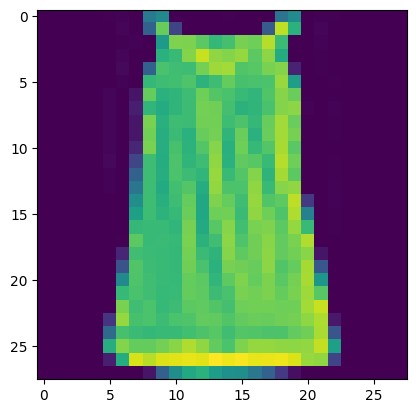

La imagen verdaderamente es un T-shirt/top
El modelo predice que es un(a) Shirt
¿Éxito? ->  True
predicción de la imagen adversaria  Shirt


In [37]:
# Ataque adversario

fashion_mnist_labels = {
                        0: 'T-shirt/top',
                        1: 'Trouser',
                        2: 'Pullover',
                        3: 'Dress',
                        4: 'Coat',
                        5: 'Sandal',
                        6: 'Shirt',
                        7: 'Sneaker',
                        8: 'Bag',
                        9: 'Ankle boot'
                        }

index = 4

image_data = X[index]
image_data = image_data.reshape(1, -1)

plt.imshow(image_data.reshape(28, 28))
plt.show()

y_true = y[index]

print(f"La imagen verdaderamente es un {fashion_mnist_labels[y_true]}")

# model = Model.load("fashion_mnist.model")

# Predigo la clase de la imagen con mi modelo
confidences = model.predict(image_data)
predictions = model.output_layer_activation.predictions(confidences)  # [0, 0, 0, 1, 0, 0, 0]

prediction_str = fashion_mnist_labels[predictions[0]]

print(f"El modelo predice que es un(a) {prediction_str}")

x_adv, adv_prediction, perturbation, success = generate_adversarial_rnn(model, image_data, y_true)

print("¿Éxito? -> ", success)
print("predicción de la imagen adversaria ", fashion_mnist_labels[adv_prediction[0]])

In [38]:

working_ids = []
for sample in range(len(X)):
    image_data = X[sample]
    image_data = image_data.reshape(1, -1)
    y_true = y[sample]

    true_label = fashion_mnist_labels[y_true]  # str
    # model = Model.load("fashion_mnist.model")

    # Predigo la clase de la imagen con mi modelo
    confidences = model.predict(image_data)
    predictions = model.output_layer_activation.predictions(confidences)

    prediction = fashion_mnist_labels[predictions[0]]

    if true_label != prediction:
        continue

    x_adv, adv_prediction, perturbation, success = generate_adversarial_rnn(model, image_data, y_true)

    if success:
        working_ids.append(sample)
        print("¡Éxito!")
        print("Funciona para la muestra de id:", sample)
        print(" > La etiqueta real era: ", true_label)
        print(" > La predicción del modelo con la img original era: ", prediction)
        print(" > La predicción del modelo con la img adversaria es: ", fashion_mnist_labels[adv_prediction[0]])


¡Éxito!
Funciona para la muestra de id: 14
 > La etiqueta real era:  T-shirt/top
 > La predicción del modelo con la img original era:  T-shirt/top
 > La predicción del modelo con la img adversaria es:  Shirt
¡Éxito!
Funciona para la muestra de id: 48
 > La etiqueta real era:  Shirt
 > La predicción del modelo con la img original era:  Shirt
 > La predicción del modelo con la img adversaria es:  Coat
¡Éxito!
Funciona para la muestra de id: 50
 > La etiqueta real era:  Pullover
 > La predicción del modelo con la img original era:  Pullover
 > La predicción del modelo con la img adversaria es:  Shirt
¡Éxito!
Funciona para la muestra de id: 64
 > La etiqueta real era:  Shirt
 > La predicción del modelo con la img original era:  Shirt
 > La predicción del modelo con la img adversaria es:  Coat
¡Éxito!
Funciona para la muestra de id: 87
 > La etiqueta real era:  Shirt
 > La predicción del modelo con la img original era:  Shirt
 > La predicción del modelo con la img adversaria es:  Pullover
¡

KeyboardInterrupt: 

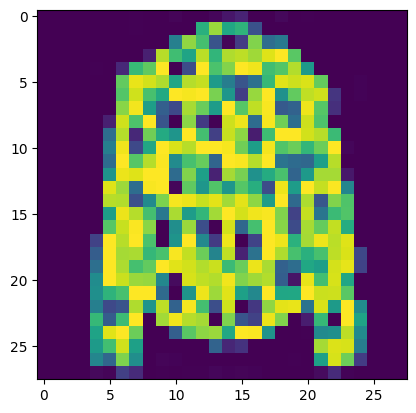

La imagen verdaderamente es un Shirt
El modelo predice que es un(a) Shirt
¿Éxito? ->  True
predicción de la imagen adversaria  Coat


In [49]:
# Ataque adversario

sample = 64

image_data = X[sample]
image_data = image_data.reshape(1, -1)

plt.imshow(image_data.reshape(28, 28))
plt.show()

y_true = y[sample]

print(f"La imagen verdaderamente es un {fashion_mnist_labels[y_true]}")

# model = Model.load("fashion_mnist.model")

# Predigo la clase de la imagen con mi modelo
confidences = model.predict(image_data)
predictions = model.output_layer_activation.predictions(confidences)  # [0, 0, 0, 1, 0, 0, 0]

prediction_str = fashion_mnist_labels[predictions[0]]

print(f"El modelo predice que es un(a) {prediction_str}")

x_adv, adv_prediction, perturbation, success = generate_adversarial_rnn(model, image_data, y_true)

print("¿Éxito? -> ", success)
print("predicción de la imagen adversaria ", fashion_mnist_labels[adv_prediction[0]])

Original


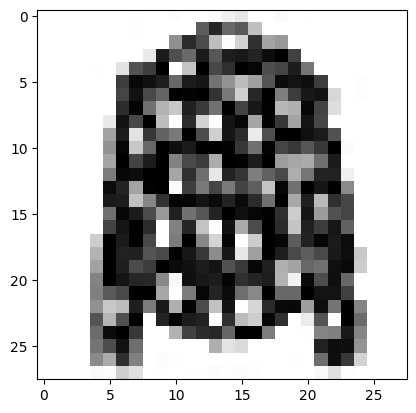

Adversaria


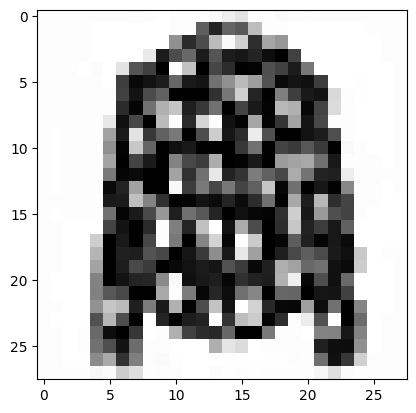

Perturbación (epsilon)


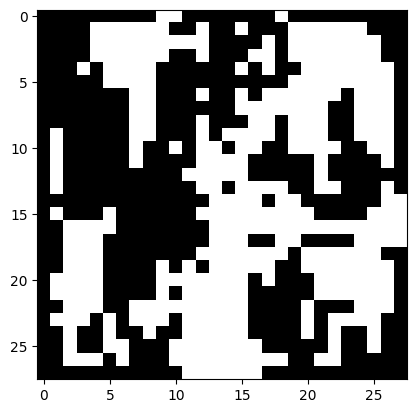

In [50]:
rev_image_data = (image_data * 127.5) + 127.5

rev_image_data = 255 - rev_image_data

rev_image_data = np.clip(rev_image_data, 0, 255)

rev_image_data = rev_image_data.reshape((28, 28)).astype(np.uint8)

print("Original")
plt.imshow(rev_image_data, cmap="gray")
plt.show()

rev_adv_image_data = (x_adv * 127.5) + 127.5

rev_adv_image_data = 255 - rev_adv_image_data

rev_adv_image_data = np.clip(rev_adv_image_data, 0, 255)

rev_adv_image_data = rev_adv_image_data.reshape((28, 28)).astype(np.uint8)

print("Adversaria")
plt.imshow(rev_adv_image_data, cmap="gray")
plt.show()


rev_perturbation = (perturbation * 127.5) + 127.5

rev_perturbation = 255 - rev_perturbation

rev_perturbation = np.clip(rev_perturbation, 0, 255)

rev_perturbation = rev_perturbation.reshape((28, 28)).astype(np.uint8)

print("Perturbación (epsilon)")
plt.imshow(rev_perturbation, cmap="gray")
plt.show()